In [1]:
import argparse
import numpy as np
import random
import torch
import os

import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Subset, DataLoader

from transformers import AdamW, get_linear_schedule_with_warmup
from typing import List
import time
from accelerate import Accelerator
from accelerate import DistributedDataParallelKwargs

from watchog.dataset import TableDataset, SupCLTableDataset
from watchog.model import SupCLforTable, UnsupCLforTable, SupclLoss
import wandb

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import torch
import seaborn as sns

[nltk_data] Downloading package punkt to /home/zhihao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zhihao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
    parser = argparse.ArgumentParser()
    parser.add_argument("--model", type=str, default="Watchog") # simclr for original CL, supcon for CL using metadata
    parser.add_argument("--pretrain_data", type=str, default="wikitables") # dataset for pretraining
    parser.add_argument("--pretrained_model_path", type=str, default="") # pretrained checkpoint 
    parser.add_argument("--data_path",type=str, default="/data/zhihao/TU/TURL/")
    parser.add_argument("--mode", type=str, default="simclr") # simclr for original CL, supcon for CL using metadata
    parser.add_argument("--logdir", type=str, default="/data/zhihao/TU/Watchog/model/") # directory to store model checkpoints
    parser.add_argument("--run_id", type=int, default=0)
    parser.add_argument("--batch_size", type=int, default=32)
    parser.add_argument("--max_len", type=int, default=128)
    parser.add_argument("--size", type=int, default=10000)
    parser.add_argument("--lr", type=float, default=5e-5)
    parser.add_argument("--n_epochs", type=int, default=20)
    parser.add_argument("--lm", type=str, default='bert')
    parser.add_argument("--projector", type=int, default=768)
    parser.add_argument("--augment_op", type=str, default='sample_row4,sample_row4')
    parser.add_argument("--table_order", type=str, default='column')
    parser.add_argument("--sample_meth", type=str, default='tfidf_entity')
    parser.add_argument("--temperature", type=float, default=0.05)
    parser.add_argument("--save_model", type=int, default=5)
    parser.add_argument("--fp16", dest="fp16", default=True, action="store_true")
    parser.add_argument("--gpus", type=str, default="0")
    parser.add_argument("--single_column", default=False)
    
    hp = parser.parse_args([])

# Ontology

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import torch
import seaborn as sns

In [46]:
import glob
table_names = glob.glob('/data/zhihao/TU/GitTables/semtab_gittables/2022/tables/*')

In [135]:
len(table_names)

6892

In [73]:
import glob
table_names_21 = glob.glob('/data/zhihao/TU/GitTables/semtab_gittables/2021/tables/*')

In [75]:
set(table_names_21).intersection(set(table_names))

set()

In [74]:
len(table_names_21)

1101

In [48]:
len(table_names)

6892

In [9]:
import pickle
dbpedia_ontology = pickle.load(open("/data/zhihao/TU/GitTables/dbpedia_20210528.pkl", 'rb'))
schema_ontology = pickle.load(open("/data/zhihao/TU/GitTables/schema_20210528.pkl", 'rb'))

In [101]:
df_table = pd.read_csv('/data/zhihao/TU/GitTables/semtab_gittables/2022/tables/GitTables_2727.csv')

In [103]:
df_table = pd.read_csv('/data/zhihao/TU/GitTables/semtab_gittables/2022/tables/GitTables_6415.csv')

In [104]:
df_table

,col0,col1,col2,col3
0,2990001,2250001,2070001,V1
1,2990002,2250001,2070002,V2
2,2990003,2250001,2070003,V3
3,2990004,2250001,2070005,V4
4,2990005,2250001,2070004,V4
5,2990006,2250001,2070010,V3
6,2990007,2250001,2070006,V5
7,2990008,2250001,2070007,V5
8,2990009,2250001,2070008,V5
9,2990011,2250001,2070012,V0


In [3]:
df_target_train = pd.read_csv("/data/zhihao/TU/GitTables/semtab_gittables/2022/dbpedia_property_train.csv")
df_target_test = pd.read_csv("/data/zhihao/TU/GitTables/semtab_gittables/2022/dbpedia_property_targets.csv")
df_gt_2021 = pd.read_csv("/data/zhihao/TU/GitTables/semtab_gittables/2021/dbpedia_gt.csv")
df_target_2021 = pd.read_csv("/data/zhihao/TU/GitTables/semtab_gittables/2021/dbpedia_targets.csv")

In [4]:

from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
    KFold,
    ShuffleSplit,
    StratifiedGroupKFold,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
)

In [14]:
index = np.arange(len(df_target_train))
labels = np.array([t.split("/")[-1] for t in df_target_train["annotation_id"].values])
table_ids = np.array([int(t.split("_")[-1]) for t in df_target_train["table_id"].values])

In [20]:
df_target_train[df_target_train["table_id"] == "GitTables_102063"]

,table_id,target_column,annotation_id
3435,GitTables_102063,20,http://dbpedia.org/ontology/type
5767,GitTables_102063,6,http://dbpedia.org/ontology/time


In [7]:
import os
base_dirpath= "/data/zhihao/TU/GitTables/semtab_gittables/2022"
basename = 'semi1'+ "_cv_{}.csv"
df_list = []
for i in range(5):
    filepath = os.path.join(base_dirpath, basename.format(i))
    df_list.append(pd.read_csv(filepath))
df_full = pd.concat(df_list, axis=0)

193


<Axes: ylabel='Count'>

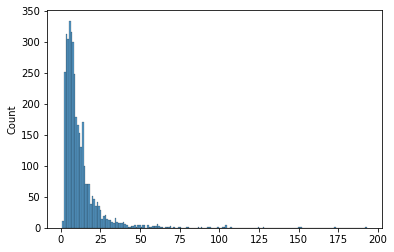

In [8]:
df_group = df_full.groupby("table_id")
column_num = []
for i, (index, group_df) in enumerate(df_group):
    column_num.append(len(group_df))
print(max(column_num))
sns.histplot(column_num)

7


<Axes: ylabel='Count'>

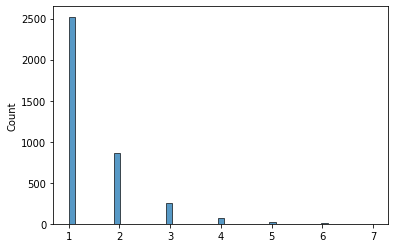

In [9]:

df_group = df_full.groupby("table_id")
column_num = []
for i, (index, group_df) in enumerate(df_group):
    group_df = group_df[group_df["class_id"] > -1]
    if len(group_df) == 0:
        continue
    column_num.append(len(group_df))
print(max(column_num))
sns.histplot(column_num) # TODO: why there is zero

0.8800768144093237


<Axes: >

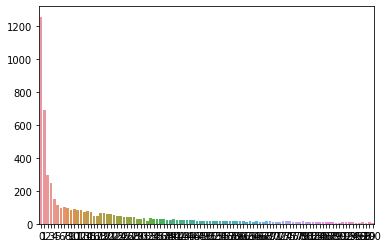

In [11]:
class_samples = df_full["class_id"].value_counts().sort_index().values[1:]
print(df_full["class_id"].value_counts().sort_index().values[0]/sum(df_full["class_id"].value_counts().sort_index().values))
sns.barplot(x=np.arange(len(class_samples)), y=class_samples)

In [39]:
df_target_train_group = df_target_train.groupby('table_id')
df_target_test_group = df_target_test.groupby('table_id')

In [149]:
types 

array(['id', 'name', 'description', 'type', 'title', 'state', 'status',
       'date', 'code', 'city', 'value', 'source', 'year', 'time',
       'country', 'county', 'comment', 'notes', 'category', 'address',
       'age', 'gender', 'location', 'version', 'price', 'sex',
       'startDate', 'weight', 'class', 'endDate', 'field', 'region',
       'note', 'race', 'duration', 'species', 'score', 'position',
       'start', 'language', 'rank', 'height', 'population', 'order',
       'length', 'filename', 'model', 'role', 'series', 'max', 'min',
       'family', 'currency', 'definition', 'format', 'author', 'area',
       'domain', 'rating', 'parent', 'number', 'birthDate', 'alias',
       'postalCode', 'reference', 'cost', 'publisher', 'treatment',
       'created', 'company', 'district', 'elevation', 'project', 'day',
       'end', 'scientificName', 'abbreviation', 'part', 'countryCode',
       'season', 'topic', 'depth', 'road', 'prefix', 'month', 'route',
       'width', 'department', '

In [12]:
types = np.array([t.split("/")[-1] for t in df_target_train["annotation_id"].value_counts().index.values])
type2id = {t: i for i, t in enumerate(types)}
id2type = {i: t for i, t in enumerate(types)}
column_categories = {
    "Numerical": ['age', 'value', 'price', 'weight', 'score', 'rank', 'height', 'population', 'order', 'length', 'max', 'min', 'number', 'cost', 'elevation', 'depth', 'width', 'percentage'],
    "Categorical": ['id', 'name', 'description', 'type', 'title', 'state', 'status', 'code', 'city', 'source', 'country', 'county', 'comment', 'notes', 'category', 'address', 'gender', 'location', 'version', 'sex', 'class', 'field', 'region', 'note', 'race', 'species', 'position', 'language', 'filename', 'model', 'role', 'series', 'family', 'currency', 'definition', 'format', 'author', 'area', 'domain', 'rating', 'parent', 'alias', 'postalCode', 'reference', 'publisher', 'treatment', 'company', 'district', 'project', 'scientificName', 'abbreviation', 'part', 'countryCode', 'topic', 'road', 'prefix', 'route', 'department', 'zipCode', 'abstract', 'event', 'creator', 'genus', 'tag', 'owner', 'party', 'result'],
    "Datetime": ['date', 'time', 'startDate', 'endDate', 'birthDate', 'created', 'day', 'end', 'month', 'period', 'releaseDate', 'season'],
    "Other": ['start', 'duration', 'project', 'frequency']
}
is_numerical = np.array([t in column_categories["Numerical"] for t in types])
is_categorical = np.array([t in column_categories["Categorical"] for t in types])
is_datetime = np.array([t in column_categories["Datetime"] for t in types])
is_other = np.array([t in column_categories["Other"] for t in types])

# Results analysis

In [13]:
import argparse
import json
import math
import os
import random
from time import time

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import torch
import seaborn as sns

types = np.array(['id', 'name', 'description', 'type', 'title', 'state', 'status',
       'date', 'code', 'city', 'value', 'source', 'year', 'time',
       'country', 'county', 'comment', 'notes', 'category', 'address',
       'age', 'gender', 'location', 'version', 'price', 'sex',
       'startDate', 'weight', 'class', 'endDate', 'field', 'region',
       'note', 'race', 'duration', 'species', 'score', 'position',
       'start', 'language', 'rank', 'height', 'population', 'order',
       'length', 'filename', 'model', 'role', 'series', 'max', 'min',
       'family', 'currency', 'definition', 'format', 'author', 'area',
       'domain', 'rating', 'parent', 'number', 'birthDate', 'alias',
       'postalCode', 'reference', 'cost', 'publisher', 'treatment',
       'created', 'company', 'district', 'elevation', 'project', 'day',
       'end', 'scientificName', 'abbreviation', 'part', 'countryCode',
       'season', 'topic', 'depth', 'road', 'prefix', 'month', 'route',
       'width', 'department', 'percentage', 'zipCode', 'abstract',
       'event', 'creator', 'frequency', 'releaseDate', 'genus', 'tag',
       'owner', 'party', 'period', 'result'])
type2id = {t: i for i, t in enumerate(types)}
id2type = {i: t for i, t in enumerate(types)}
column_categories = {
    "Numerical": ['age', 'value', 'price', 'weight', 'score', 'rank', 'height', 'population', 'order', 'length', 'max', 'min', 'number', 'cost', 'elevation', 'depth', 'width', 'percentage'],
    "Categorical": ['id', 'name', 'description', 'type', 'title', 'state', 'status', 'code', 'city', 'source', 'country', 'county', 'comment', 'notes', 'category', 'address', 'gender', 'location', 'version', 'sex', 'class', 'field', 'region', 'note', 'race', 'species', 'position', 'language', 'filename', 'model', 'role', 'series', 'family', 'currency', 'definition', 'format', 'author', 'area', 'domain', 'rating', 'parent', 'alias', 'postalCode', 'reference', 'publisher', 'treatment', 'company', 'district', 'project', 'scientificName', 'abbreviation', 'part', 'countryCode', 'topic', 'road', 'prefix', 'route', 'department', 'zipCode', 'abstract', 'event', 'creator', 'genus', 'tag', 'owner', 'party', 'result'],
    "Datetime": ['date', 'time', 'startDate', 'endDate', 'birthDate', 'created', 'day', 'end', 'month', 'period', 'releaseDate', 'season'],
    "Other": ['start', 'duration', 'project', 'frequency']
}
is_numerical = np.array([t in column_categories["Numerical"] for t in types])
is_categorical = np.array([t in column_categories["Categorical"] for t in types])
is_datetime = np.array([t in column_categories["Datetime"] for t in types])
is_other = np.array([t in column_categories["Other"] for t in types])

In [15]:

base_dirpath = "/data/zhihao/TU/GitTables/semtab_gittables/2022/"
seperator = "semi1"
basename = seperator+"_cv_{}.csv"
df_list = []
cv = 0
filepath = os.path.join(base_dirpath, basename.format(cv))
df_test = pd.read_csv(filepath)

df_group_test = df_test.groupby("table_id")



df_list = []
for i in range(5):
    if i == cv:
        continue
    filepath = os.path.join(base_dirpath, basename.format(i))
    df_list.append(pd.read_csv(filepath))
df_train = pd.concat(df_list, axis=0)
df_group_train = df_train.groupby("table_id")

In [16]:
# analyze col correlation
corr_matrix = np.zeros((len(types), len(types)))
for i, (index, group_df) in enumerate(df_group_train):
    if len(group_df) == 0:
        continue
    class_ids = group_df[group_df["class_id"] > -1]["class_id"].values
    for i in range(len(class_ids)):
        for j in range(i+1, len(class_ids)):
            corr_matrix[class_ids[i], class_ids[j]] += 1
            corr_matrix[class_ids[j], class_ids[i]] += 1

In [62]:
null_tables = []
for i, group_df in df_group_train:
    if len(group_df[group_df['class_id'] > -1]) == 0:
        null_tables.append(i)

In [20]:
import json
import numpy as np

# Function to load confusion matrix from JSON file
# with open("/data/zhihao/TU/doduo/eval/sato0_mosato_bert_bert-base-uncased-bs16-ml-32__sato0-1.00=sato0.json", 'r') as f:
#     results = json.load(f)
with open(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all{cv}/bert-base-uncased-fromscratch-semi1-pool@v0-max_num_col@8-poolv0-max_cols8-randFalse-bs16-ml64-ne50-do0.1_eval.json", 'r') as f:
    results = json.load(f)

# labels_train = np.array(results['train']['tr_true_list'])
# preds_train = np.array(results['train']['tr_pred_list'])
# class_f1_train = np.array(results['train']['tr_class_f1'])

labels_context = np.array(results['f1_micro']['true_list'])
preds_context = np.array(results['f1_micro']['pred_list'])
class_f1_context = np.array(results['f1_micro']['ts_class_f1'])
assert len(labels_context) == len(df_test["class_id"][df_test["class_id"]>-1])


In [22]:
import json
import numpy as np

# Function to load confusion matrix from JSON file
# with open("/data/zhihao/TU/doduo/eval/sato0_mosato_bert_bert-base-uncased-bs16-ml-32__sato0-1.00=sato0.json", 'r') as f:
#     results = json.load(f)
with open(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all{cv}/bert-base-uncased-fromscratch-semi1-pool@v0-max_num_col@1-poolv0-max_cols1-randFalse-bs16-ml64-ne50-do0.1_eval.json", 'r') as f:
    results = json.load(f)

# labels_train = np.array(results['train']['tr_true_list'])
# preds_train = np.array(results['train']['tr_pred_list'])
# class_f1_train = np.array(results['train']['tr_class_f1'])

labels = np.array(results['f1_micro']['true_list'])
preds = np.array(results['f1_micro']['pred_list'])
class_f1 = np.array(results['f1_micro']['ts_class_f1'])
assert len(labels) == len(df_test["class_id"][df_test["class_id"]>-1])

In [34]:
target_class_ids = []
max_gap = 0
max_gap_id = -1
for i in range(len(class_f1)):
    if (class_f1[i] - class_f1_context[i] > 0.01):
        target_class_ids.append(i)
        print(i, types[i], class_f1[i], class_f1_context[i], class_count[i], class_count_test[i])
        if class_f1[i] - class_f1_context[i] > max_gap:
            max_gap = class_f1[i] - class_f1_context[i]
            max_gap_id = i

2 description 0.53125 0.4590163934426229 240 58.0
3 type 0.5510204081632654 0.5348837209302325 201 46.0
4 title 0.49315068493150693 0.47887323943661975 119 30.0
5 state 0.5384615384615385 0.5116279069767442 90 22.0
6 status 0.5454545454545454 0.4864864864864864 73 21.0
7 date 0.5490196078431373 0.4545454545454545 82 21.0
10 value 0.391304347826087 0.33333333333333337 72 18.0
12 year 0.8571428571428572 0.7894736842105263 68 16.0
13 time 0.33333333333333337 0.09523809523809522 57 15.0
15 county 0.923076923076923 0.8571428571428571 59 14.0
16 comment 0.2857142857142857 0.14285714285714285 39 7.0
20 age 0.7199999999999999 0.6206896551724138 49 13.0
24 price 0.35294117647058826 0.16666666666666666 41 9.0
27 weight 0.13333333333333333 0.0 31 8.0
35 species 0.5 0.4615384615384615 21 7.0
36 score 0.4 0.125 23 7.0
37 position 0.28571428571428575 0.22222222222222224 24 5.0
39 language 0.5714285714285715 0.33333333333333337 20 5.0
41 height 0.6 0.4444444444444444 18 6.0
42 population 0.5714285714

In [67]:
# num = 0
# wrong_num = 0
# target_type = "domain"
# target_type_id = i = np.where(types==target_type )[0][0]
# print(i, types[i], class_f1[i], class_f1_context[i], class_count[i], class_count_test[i])
# print("================================")
# for i, (index, group_df) in enumerate(df_group_train):
#     if target_type in group_df["class"].values:
#         # if (types[preds_context[labels==target_type_id]][num] != target_type) and (types[preds[labels==target_type_id]][num] == target_type):
#         #     print(types[preds[labels==target_type_id]][num], "||", types[preds_context[labels==target_type_id]][num])
#         #     print(group_df[group_df["class_id"]>-1][["class", "data"]])
#         #     wrong_num += 1
#         #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
#         #     print("================================")
#         #     if wrong_num > 30:
#         #         break
        
        
#         # print(types[preds[labels==target_type_id]][num], "||", types[preds_context[labels==target_type_id]][num])
#         print(group_df[group_df["class_id"]>-1][["class", "data"]])
#         print(group_df[group_df["class_id"]==-1][["class", "data"]])
#         print("================================")
#         break
#         num += 1
#         # if num > 20:
#         #     break

In [68]:
num = 0
wrong_num = 0
target_type = "department"
target_type_id = i = np.where(types==target_type )[0][0]
print(i, types[i], class_f1[i], class_f1_context[i], class_count[i], class_count_test[i])
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        if (types[preds_context[labels==target_type_id]][num] != target_type) and (types[preds[labels==target_type_id]][num] == target_type):
            print(types[preds[labels==target_type_id]][num], "||", types[preds_context[labels==target_type_id]][num])
            print(group_df[group_df["class_id"]>-1][["class", "data"]])
            wrong_num += 1
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
            if wrong_num > 30:
                break
        
        
        # print(types[preds[labels==target_type_id]][num], "||", types[preds_context[labels==target_type_id]][num])
        # print(group_df[group_df["class_id"]>-1][["class", "data"]])
        # print(group_df[group_df["class_id"]==-1][["class", "data"]])
        # print("================================")
        num += 1
        # if num > 20:
        #     break

87 department 0.6666666666666666 0.0 6 2.0
department || name
           class                                               data
1349  department  Department for Transport;Department for Enviro...
1356        road  LANDSEER ROAD;CREWE BUSINESS PARK;MILFORD STRE...
     class                                               data
1348   NaN  Central Civil Estate;Central Civil Estate;Cent...
1350   NaN  DFT - VEHICLE AND OPERATOR SERVICES AGENCY;DEF...
1351   NaN  East of England;North West;South West;South We...
1352   NaN  791639;109198;374692;379904;277942;605256;1037...
1353   NaN                                1;2;1;1;5;1;1;6;1;2
1354   NaN  IPSWICH TEST STATION;CREWE ELECTRA WAY;SALISBU...
1355   NaN  VEHICLE TEST STATION;Crewe, Electra Way - Offi...
1357   NaN  IPSWICH;CREWE;SALISBURY;GLOUCESTER;DERBY;RUGBY...
1358   NaN  Ipswich Ipswich District United Kingdom of Gre...
1359   NaN  IP3 0DF;CW1 6GJ;SP1 2BP;GL1 1DQ;DE24 8UP;CV21 ...
1360   NaN  52.038159;53.091798;51.068582;51.864676;

In [55]:
num = 0
wrong_num = 0
target_type = "title"
target_type_id = i = np.where(types==target_type )[0][0]
print(i, types[i], class_f1[i], class_f1_context[i], class_count[i], class_count_test[i])
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        if (types[preds_context[labels==target_type_id]][num] != target_type) and (types[preds[labels==target_type_id]][num] == target_type):
            print(types[preds[labels==target_type_id]][num], "||", types[preds_context[labels==target_type_id]][num])
            print(group_df[group_df["class_id"]>-1][["class", "data"]])
            wrong_num += 1
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
            if wrong_num > 30:
                break
        
        
        # print(types[preds[labels==target_type_id]][num], "||", types[preds_context[labels==target_type_id]][num])
        # print(group_df[group_df["class_id"]>-1][["class", "data"]])
        # print(group_df[group_df["class_id"]==-1][["class", "data"]])
        # print("================================")
        num += 1
        # if num > 20:
        #     break

4 title 0.49315068493150693 0.47887323943661975 119 30.0
title || description
          class                                               data
3487         id  R01MH096906;R01MH109682;R24MH120037;1760950;UH...
3488      title  LARGE-SCALE IMAGE-BASED META-ANALYSIS OF FUNCT...
3490  startDate  2012;2016;2019;2018;2018;2018;2018;2017;2017;2...
3491    endDate  2023;2021;2024;2021;2020;2023;2023;2020;2020;2...
     class                                               data
3486   NaN  National Institute of Mental Health;National I...
3489   NaN  Subcontract PI (T. Yarkoni, PI);Subcontract PI...
3492   NaN  True;True;True;True;True;True;True;True;False;...
3493   NaN  https://projectreporter.nih.gov/project_info_d...
title || name
      class                                               data
3991  title  \nAesthetic Blasphemy\n;Login to Aesthetic Bla...
     class                                               data
3990   NaN  http://aestheticblasphemy.com;http://aesthetic...
3992   NaN  2

In [50]:
num = 0
wrong_num = 0
target_type = "postalCode"
target_type_id = i = np.where(types==target_type )[0][0]
print(i, types[i], class_f1[i], class_f1_context[i], class_count[i], class_count_test[i])
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        if (types[preds_context[labels==target_type_id]][num] != target_type) and (types[preds[labels==target_type_id]][num] == target_type):
            print(types[preds[labels==target_type_id]][num], "||", types[preds_context[labels==target_type_id]][num])
            print(group_df[group_df["class_id"]>-1][["class", "data"]])
            wrong_num += 1
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
            if wrong_num > 30:
                break
        
        
        # print(types[preds[labels==target_type_id]][num], "||", types[preds_context[labels==target_type_id]][num])
        # print(group_df[group_df["class_id"]>-1][["class", "data"]])
        # print(group_df[group_df["class_id"]==-1][["class", "data"]])
        # print("================================")
        num += 1
        # if num > 20:
        #     break

63 postalCode 0.5714285714285715 0.4444444444444445 12 4.0
postalCode || id
           class                                               data
7006  postalCode  37608;14301;63379;38690;16311;58957;20720;4559...
     class                                               data
7003   NaN  309 Anthony Roads\nNew Maria, MO 12498;90321 C...
7004   NaN  3019 Gerald Mall Apt. 340\nTrevinoville, SD 36...
7005   NaN  ID;ID;ID;ID;ID;ID;ID;ID;ID;ID;ID;ID;ID;ID;ID;I...


In [46]:
target_type = "title"
target_type_id = i = np.where(types==target_type )[0][0]
corr_order = np.argsort(corr_matrix[target_type_id])
print(types[target_type_id])
print("==================================")
for i in range(10):
    print(types[corr_order[-i-1]], corr_matrix[target_type_id][corr_order[-i-1]])

title
id 17.0
description 14.0
name 8.0
type 6.0
date 5.0
format 4.0
author 4.0
period 3.0
birthDate 3.0
publisher 3.0


In [49]:
target_type = "description"
target_type_id = i = np.where(types==target_type )[0][0]
corr_order = np.argsort(corr_matrix[target_type_id])
print(types[target_type_id])
print("==================================")
for i in range(10):
    print(types[corr_order[-i-1]], corr_matrix[target_type_id][corr_order[-i-1]])

description
name 43.0
id 41.0
type 26.0
title 14.0
status 9.0
value 9.0
category 8.0
address 6.0
part 5.0
date 5.0


In [45]:
num = 0
wrong_num = 0
target_type = "description"
target_type_id = i = np.where(types==target_type )[0][0]
print(i, types[i], class_f1[i], class_f1_context[i], class_count[i], class_count_test[i])
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        if (types[preds_context[labels==target_type_id]][num] != target_type) and (types[preds[labels==target_type_id]][num] == target_type):
            print(types[preds[labels==target_type_id]][num], "||", types[preds_context[labels==target_type_id]][num])
            print(group_df[group_df["class_id"]>-1][["class", "data"]])
            wrong_num += 1
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
            if wrong_num > 30:
                break
        
        
        # print(types[preds[labels==target_type_id]][num], "||", types[preds_context[labels==target_type_id]][num])
        # print(group_df[group_df["class_id"]>-1][["class", "data"]])
        # print(group_df[group_df["class_id"]==-1][["class", "data"]])
        # print("================================")
        num += 1
        # if num > 20:
        #     break

2 description 0.53125 0.4590163934426229 240 58.0
description || title
            class                                               data
2292         name  Securing Peace;Respecting Rights;Saving Lives;...
2293  description  The Department of State plays a vital role in ...
     class                                               data
2294   NaN  securityKey;rightsKey;livesKey;environmentKey;...
2295   NaN         security;rights;lives;environment;business
2296   NaN  securityDrop;rightsDrop;livesDrop;environmentD...
description || name
            class                                               data
2909  description  mobile Fish;Chips;Multi-channelled Licensed;Na...
     class                                               data
2908   NaN                               1;2;3;4;5;6;7;8;9;10
2910   NaN  2019-07-24T22:10:06;2019-07-25T12:28:44;2019-0...
2911   NaN  59865;61748;19967;68326;77513;96525;7404;38292...
2912   NaN  59685;30424;38246;12203;44975;28093;92630;1195...
2913  

In [42]:
num = 0
wrong_num = 0
target_type = "department"
target_type_id = i = np.where(types==target_type )[0][0]
print(i, types[i], class_f1[i], class_f1_context[i], class_count[i], class_count_test[i])
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        # if (types[preds_context[labels==target_type_id]][num] != target_type) and (types[preds[labels==target_type_id]][num] == target_type):
        #     print(types[preds[labels==target_type_id]][num], "||", types[preds_context[labels==target_type_id]][num])
        #     print(group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        
        
        print(types[preds[labels==target_type_id]][num], "||", types[preds_context[labels==target_type_id]][num])
        print(group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        # if num > 20:
        #     break

87 department 0.6666666666666666 0.0 6 2.0
department || name
           class                                               data
1349  department  Department for Transport;Department for Enviro...
1356        road  LANDSEER ROAD;CREWE BUSINESS PARK;MILFORD STRE...
     class                                               data
1348   NaN  Central Civil Estate;Central Civil Estate;Cent...
1350   NaN  DFT - VEHICLE AND OPERATOR SERVICES AGENCY;DEF...
1351   NaN  East of England;North West;South West;South We...
1352   NaN  791639;109198;374692;379904;277942;605256;1037...
1353   NaN                                1;2;1;1;5;1;1;6;1;2
1354   NaN  IPSWICH TEST STATION;CREWE ELECTRA WAY;SALISBU...
1355   NaN  VEHICLE TEST STATION;Crewe, Electra Way - Offi...
1357   NaN  IPSWICH;CREWE;SALISBURY;GLOUCESTER;DERBY;RUGBY...
1358   NaN  Ipswich Ipswich District United Kingdom of Gre...
1359   NaN  IP3 0DF;CW1 6GJ;SP1 2BP;GL1 1DQ;DE24 8UP;CV21 ...
1360   NaN  52.038159;53.091798;51.068582;51.864676;

In [41]:
num = 0
wrong_num = 0
target_type = "season"
target_type_id = i = np.where(types==target_type )[0][0]
print(i, types[i], class_f1[i], class_f1_context[i], class_count[i], class_count_test[i])
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        # if (types[preds_context[labels==target_type_id]][num] != target_type) and (types[preds[labels==target_type_id]][num] == target_type):
        #     print(types[preds[labels==target_type_id]][num], "||", types[preds_context[labels==target_type_id]][num])
        #     print(group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        
        
        print(types[preds[labels==target_type_id]][num], "||", types[preds_context[labels==target_type_id]][num])
        print(group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        # if num > 20:
        #     break

79 season 0.5 0.0 11 3.0
year || year
        class                                               data
657    season  2014;2014;2014;2014;2014;2014;2014;2014;2014;2...
658    region  MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;S...
661      name  MW Round2 Game 1;MW Round2 Game 2;MW Round2 Ga...
667  location  Nowhere;Nowhere;Nowhere;Nowhere;Nowhere;Nowher...
    class                                               data
656   NaN  2014R1G1MW;2014R1G2MW;2014R1G3MW;2014R1G4MW;20...
659   NaN  WIST;UK;STL;LOUI;MASS;DUKE;TEX;MICH;WIST;STL;T...
660   NaN  CALP;KSST;NCST;MAN;TENN;MERC;AZST;WOF;UK;LOUI;...
662   NaN  1;1;1;1;1;1;1;1;2;2;2;2;3;3;4;1;1;1;1;1;1;1;1;...
663   NaN  1;2;3;4;5;6;7;8;1;2;3;4;1;2;1;1;2;3;4;5;6;7;8;...
664   NaN  67;56;83;71;67;71;87;57;76;51;83;65;74;71;75;6...
665   NaN  37;49;80;64;86;78;85;40;78;66;63;79;69;73;72;5...
666   NaN  2014-03-17;2014-03-17;2014-03-17;2014-03-18;20...
endDate || date
       class                      data
5007  season  2020;2020;2020;2020

In [33]:
i = max_gap_id
print(i,  types[i], class_f1[i], class_f1_context[i], class_count[i], class_count_test[i])

67 treatment 1.0 0.0 9 1.0


In [26]:
len(target_class_ids)

33

In [23]:
class_f1[0]

0.8141592920353982

In [24]:
class_f1_context[0]

0.8111111111111111

<Axes: >

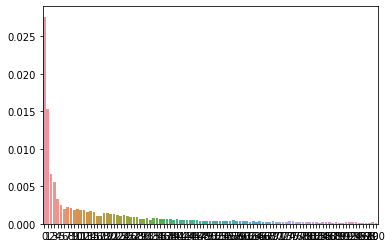

In [18]:
import seaborn as sns
class_count = df_train["class_id"][df_train["class_id"]>-1].value_counts().sort_index().values
class_freq = class_count/len(df_train)
sns.barplot(x=np.arange(len(class_freq)), y=class_freq)

<Axes: >

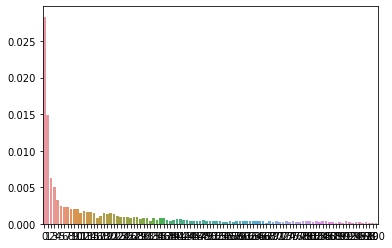

In [32]:
import seaborn as sns
class_count_test = np.zeros(len(class_count))
class_count_test[df_test["class_id"][df_test["class_id"]>-1].value_counts().sort_index().keys()] = df_test["class_id"][df_test["class_id"]>-1].value_counts().sort_index().values
class_freq_test = class_count_test/len(df_test)
sns.barplot(x=np.arange(len(class_freq_test)), y=class_freq_test)

In [19]:
num = 0
column_length_test = []
column_length_train = []
for i, (index, group_df) in enumerate(df_group_test):
    column_length_test.append(len(group_df[group_df["class_id"]>-1]))
for i, (index, group_df) in enumerate(df_group_train):
    column_length_train.append(len(group_df[group_df["class_id"]>-1]))

<Axes: ylabel='Count'>

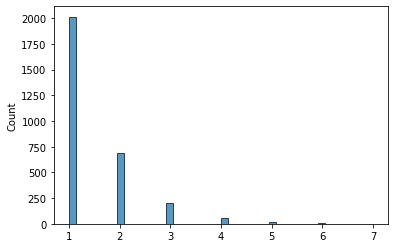

In [21]:
sns.histplot(column_length_train)

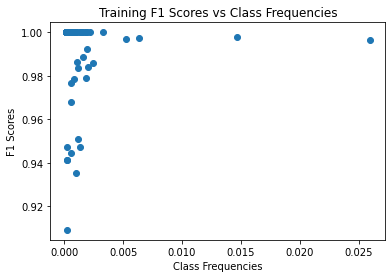

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming class_f1 and class_frequencies are your actual data
plt.scatter(class_freq, class_f1_train)
plt.xlabel('Class Frequencies')
plt.ylabel('F1 Scores')
plt.title('Training F1 Scores vs Class Frequencies')
plt.show()

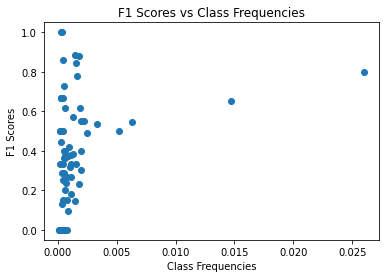

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming class_f1 and class_frequencies are your actual data
plt.scatter(class_freq, class_f1)
plt.xlabel('Class Frequencies')
plt.ylabel('F1 Scores')
plt.title('F1 Scores vs Class Frequencies')
plt.show()

In [102]:
# Training
acc_order = np.argsort(class_f1_train)
for i in range(10):
    num_train_false = sum(labels_train[labels_train == acc_order[i]] != preds_train[labels_train == acc_order[i]])
    print(types[acc_order[i]], class_f1[acc_order[i]].round(2), class_f1_train[acc_order[i]].round(2), class_count[acc_order[i]], class_count_test[acc_order[i]], "|", num_train_false)

frequency 0.0 0.91 7 1.0 | 1
sex 0.4 0.94 36 8.0 | 0
project 0.0 0.94 11 2.0 | 1
depth 0.0 0.94 9 2.0 | 1
rank 0.4 0.94 23 6.0 | 2
countryCode 0.4 0.95 9 3.0 | 0
gender 0.55 0.95 49 12.0 | 4
version 0.33 0.95 38 9.0 | 1
score 0.1 0.97 23 7.0 | 1
position 0.29 0.98 24 5.0 | 1


In [81]:
# 0
acc_order = np.argsort(class_f1)
for i in range(10):
    print(types[acc_order[-i-1]], class_f1[acc_order[-i-1]].round(2), class_f1_train[acc_order[-i-1]].round(2), class_count[acc_order[-i-1]], class_count_test[acc_order[-i-1]])

birthDate 1.0 1.0 15 4.0
address 0.96 1.0 58 15.0
county 0.92 1.0 60 14.0
family 0.86 1.0 17 4.0
currency 0.86 1.0 17 4.0
id 0.82 1.0 1036 264.0
year 0.81 0.98 73 19.0
part 0.67 1.0 10 2.0
releaseDate 0.67 1.0 8 2.0
percentage 0.67 1.0 10 1.0


In [39]:
512/12

42.666666666666664

In [17]:
freq_order = np.argsort(class_freq)
for i in range(5):
    print(types[freq_order[-i-1]], class_f1[freq_order[-i-1]], class_count[freq_order[-i-1]], class_count_test[freq_order[-i-1]])
    target_type_id = freq_order[-i-1]
    # print(pd.Series((types[preds[labels==target_type_id]])).value_counts())
    print("===================================================")
    

id 0.8183556405353729 997 260.0
name 0.6137184115523464 552 137.0
description 0.4724409448818897 240 58.0
type 0.5106382978723404 201 46.0
title 0.4482758620689655 119 30.0


name 151.0
type 50.0
description 41.0
code 25.0
title 17.0


In [38]:

freq_order = np.argsort(class_freq)
for i in range(5):
    print(types[freq_order[-i-1]], class_f1[freq_order[-i-1]], class_count[freq_order[-i-1]], class_count_test[freq_order[-i-1]])
    target_type_id = freq_order[-i-1]
    corr_order = np.argsort(corr_matrix[target_type_id])
    for j in range(5):
        print(types[corr_order[-j-1]], corr_matrix[target_type_id, corr_order[-j-1]])
    print("===================================================")

id 0.8183556405353729 997 260.0
name 151.0
type 50.0
description 41.0
code 25.0
title 17.0
name 0.6137184115523464 552 137.0
id 151.0
description 43.0
type 34.0
code 20.0
status 13.0
description 0.4724409448818897 240 58.0
name 43.0
id 41.0
type 26.0
title 14.0
status 9.0
type 0.5106382978723404 201 46.0
id 50.0
name 34.0
description 26.0
value 7.0
title 6.0
title 0.4482758620689655 119 30.0
id 17.0
description 14.0
name 8.0
type 6.0
date 5.0


In [18]:
freq_order = np.argsort(class_freq)
for i in range(5):
    print(types[freq_order[-i-1]], class_f1[freq_order[-i-1]], class_count[freq_order[-i-1]], class_count_test[freq_order[-i-1]])
    target_type_id = freq_order[-i-1]
    print(pd.Series((types[preds[labels==target_type_id]])).value_counts())
    print("===================================================")

id 0.8183556405353729 997 260.0
id             214
code             6
name             5
country          3
category         3
state            3
number           2
model            2
source           2
description      2
event            1
date             1
duration         1
startDate        1
series           1
value            1
age              1
filename         1
role             1
type             1
population       1
time             1
region           1
elevation        1
rank             1
field            1
road             1
comment          1
dtype: int64
name 0.6137184115523464 552 137.0
name           85
description    12
id             10
title           7
type            4
state           3
class           2
parent          1
domain          1
city            1
code            1
model           1
field           1
language        1
location        1
treatment       1
status          1
category        1
area            1
address         1
race            1
dtype: int6

In [225]:
np.nonzero(group_df["class_id"].values==target_type_id)[0]

array([], dtype=int64)

In [222]:
np.nonzero(group_df["class_id"].values==target_type_id)[0][0]

4

In [111]:
# num = 0
# wrong_num = 0
# target_type = "gender"
# target_type_id = np.where(types==target_type )[0][0]
# print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
# print("================================")
# for i, (index, group_df) in enumerate(df_group_train):
#     if target_type in group_df["class"].values:
#         # if types[preds_train[labels_train==target_type_id]][num] != target_type:
#         #     print(types[preds_train[labels_train==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
#         #     wrong_num += 1
#         #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
#         #     print("================================")
#         #     if wrong_num > 30:
#         #         break
        
        
#         print(types[preds_train[labels_train==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
#         print(group_df[group_df["class_id"]==-1][["class", "data"]])
#         print("================================")
#         num += 1
#         # if num > 20:
#         #     break

In [109]:
num = 0
wrong_num = 0
target_type = "gender"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_train):
    if target_type in group_df["class"].values:
        if types[preds_train[labels_train==target_type_id]][num] != target_type:
            print(types[preds_train[labels_train==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
            wrong_num += 1
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
            if wrong_num > 30:
                break
        
        
        # print(types[preds_train[labels_train==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        # print(group_df[group_df["class_id"]==-1][["class", "data"]])
        # print("================================")
        num += 1
        # if num > 20:
        #     break

0.5517241379310345 49 12.0 8
sex ||      class                                               data
51  gender  Male;Female;Male;Female;Male;Female;Male;Femal...
53    year  2019;2019;2018;2018;2017;2017;2016;2016;2015;2...
   class                                               data
50   NaN                            1;2;1;2;1;2;1;2;1;2;1;2
52   NaN  2019;2019;2018;2018;2017;2017;2016;2016;2015;2...
54   NaN  True;True;True;True;True;True;True;True;True;T...
55   NaN  True;True;True;True;True;True;True;True;True;T...
56   NaN  4567062;5158370;4592218;5085778;4630916;501927...
57   NaN  51672.1106;54804.93392;51797.83161;54417.45082...
58   NaN  36636;42837;36765;43137;36798;42403;36161;4146...
59   NaN  Restaurants & Food Services;Restaurants & Food...
60   NaN  722Z;722Z;722Z;722Z;722Z;722Z;722Z;722Z;722Z;7...
61   NaN  restaurants-food-services;restaurants-food-ser...
62   NaN  0.469599911;0.530400089;0.474500919;0.52549908...
sex ||        class                                       

IndexError: index 40 is out of bounds for axis 0 with size 40

In [91]:
(labels_train==target_type_id).sum()

6

In [90]:
num

6

In [126]:
types[preds[labels==target_type_id]]

array(['title', 'title', 'role', 'title', 'title', 'title', 'name',
       'name', 'name', 'name', 'description', 'name', 'name', 'name',
       'title', 'description', 'title', 'title', 'title', 'description',
       'title', 'title', 'title', 'title', 'name', 'prefix', 'notes',
       'description', 'title', 'name'], dtype='<U14')

In [128]:
num = 0
wrong_num = 0
target_type = "title"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        
        
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        # if num > 20:
        #     break

0.5 119 30.0 14
title ||      class                                               data
953  title  Non-competes, Business Dynamism, and Concentra...
    class                                               data
949   NaN  dataset-136;dataset-136;dataset-136;dataset-13...
950   NaN  10.2139/ssrn.3172477;10.7591/9781501717734-009...
951   NaN  SSRN Electronic Journal;{'id': 'jour.1027390',...
952   NaN  Florida WAGES;Florida WAGES;Florida WAGES;Flor...
title ||        class                                               data
1069      id  532255;6570774;3979020;548749;534719;549166;55...
1070   title  Caw;Caw!: magazine of Students for a Democrati...
1082  format  print;electronic|||electronic resource|||remot...
     class                                               data
1071   NaN  Free you (Menlo Park, Calif.)|||Human Institut...
1072   NaN  SDS fire;SDS fire;SDS new left notes;SDS new l...
1073   NaN  New York;New York, N.Y;Menlo Park, CA;Minneapo...
1074   NaN  Students for a Democr

In [129]:
num = 0
wrong_num = 0
target_type = "name"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        
        
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        # if num > 20:
        #     break

0.6488294314381272 552 137.0 97
name ||   class                                               data
0    id  state_id_0;state_id_1;state_id_2;state_id_3;st...
1  name  Alytaus apskritis;Kauno apskritis;Klaipėdos ap...
  class                                               data
2   NaN                                A;K;L;M;P;S;J;T;U;V
3   NaN  base.lt;base.lt;base.lt;base.lt;base.lt;base.l...
name ||    class                                               data
22  name  Norma Fisher;Jorge Sullivan;Elizabeth Woods;Su...
   class                                               data
23   NaN  230 Megan Junctions Suite 197\nNorth Thomas, O...
24   NaN  2700 S;1700 W;Room 100;Room 202;Room ;5325 S;2...
25   NaN  03:00 PM-07:00 PM;10:00 AM-02:00 PM;10:00 AM-0...
26   NaN  ho86815543;ho77224042;ho82147400;ho37957929;ho...
27   NaN  False;False;False;False;False;False;False;Fals...
28   NaN  True;True;True;True;True;True;True;True;True;T...
29   NaN  poll61582448;poll49054574;poll89601719;poll258..

In [135]:
num = 0
wrong_num = 0
target_type = "type"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        if types[preds[labels==target_type_id]][num] == "catogery":
            print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
            wrong_num += 1
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
            if wrong_num > 30:
                break
        
        
        # print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        # print(group_df[group_df["class_id"]==-1][["class", "data"]])
        # print("================================")
        num += 1
        # if num > 20:
        #     break


0.5652173913043478 201 46.0 26


In [230]:
# num = 0
# target_type = "id"
# target_type_id = np.where(types==target_type )[0][0]
# for i, (index, group_df) in enumerate(df_group_test):
#     if target_type in group_df["class"].values:
#         if preds[labels==target_type_id][num] != target_type_id:
#             print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
#             print("================================")
#         num += 1
#         if num > 60:
#             break

In [231]:
num = 0
target_type = "id"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print("================================")
        num += 1
        if num > 10:
            break

id ||   class                                               data
0    id  state_id_0;state_id_1;state_id_2;state_id_3;st...
1  name  Alytaus apskritis;Kauno apskritis;Klaipėdos ap...
id ||    class                                               data
43    id  1;2;3;4;5;6;857;858;859;860;861;862;1713;1714;...
46  date  2015-09-17;2015-09-17;2015-09-17;2015-09-17;20...
id ||    class                                               data
51    id  1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
rank ||       class                                               data
88  species  setosa;setosa;setosa;setosa;setosa;setosa;seto...
89       id  1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
id ||       class         data
147      id  1;2;3;4;5;6
162  status  1;1;1;1;1;1
id ||     class                                       data
219    id  1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17
id ||     class                                               data
244    id  1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;1

In [206]:
num = 0
target_type = "name"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    target_id = np.nonzero(group_df["class_id"].values==target_type_id)[0]
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print("================================")
        num += 1
        if num > 10:
            break

name ||   class                                               data
0    id  state_id_0;state_id_1;state_id_2;state_id_3;st...
1  name  Alytaus apskritis;Kauno apskritis;Klaipėdos ap...
name ||    class                                               data
22  name  Norma Fisher;Jorge Sullivan;Elizabeth Woods;Su...
name ||     class                                               data
190  name  Service 1;Cubierta 1;Cubierta 2;Cubierta 3;Cub...
name ||      class                                               data
275     id  1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
278   name  一般土建工程;电气工程;采暖工程;给排水工程;通风工程;消防预埋工程;一般土建工程;电气工程...
281  state                                                0.0
name ||         class                                               data
309      name  Mozzarella;Cheddar;Pepper Jack;Feta;Butter;Sou...
310  category  Dairy;Dairy;Dairy;Dairy;Dairy;Dairy;Dairy;Dair...
name ||     class                                               data
359    id  1;2;3;4;5;6;7;8;9;

In [186]:
# 3 birthDate, year, 
acc_order = np.argsort(class_f1)
for i in range(10):
    print(types[acc_order[-i-1]], class_f1[acc_order[-i-1]], class_count[acc_order[-i-1]], class_count_test[acc_order[-i-1]])

percentage 1.0 10 1.0
birthDate 1.0 15 4.0
address 0.8823529411764706 58 15.0
year 0.8780487804878049 73 19.0
currency 0.8571428571428571 17 4.0
county 0.8461538461538461 60 14.0
id 0.7992424242424242 1036 264.0
country 0.7777777777777778 64 17.0
filename 0.7272727272727273 20 4.0
abbreviation 0.6666666666666666 11 2.0


In [234]:
acc_order = np.argsort(class_f1)
for i in range(11, 20):
    print(types[acc_order[-i-1]], class_f1[acc_order[-i-1]], class_count[acc_order[-i-1]], class_count_test[acc_order[-i-1]])

scientificName 0.6666666666666666 12 3.0
family 0.6666666666666666 17 4.0
name 0.653968253968254 586 146.0
city 0.6190476190476191 75 20.0
species 0.6153846153846153 25 7.0
age 0.5714285714285715 52 15.0
status 0.5500000000000002 79 21.0
date 0.5490196078431373 87 22.0
description 0.5454545454545454 252 63.0


In [121]:

for i in range(41, 50):
    if  class_count_test[acc_order[-i-1]] > 5:
        print(types[acc_order[-i-1]], class_f1[acc_order[-i-1]], class_count[acc_order[-i-1]], class_count_test[acc_order[-i-1]])
        target_type_id = acc_order[-i-1]
        print(pd.Series((types[preds[labels==target_type_id]])).value_counts())
        acc_order = np.argsort(class_f1)
        print("===================================================")

version 0.3333333333333333 38 9.0
version    3
status     1
score      1
cost       1
order      1
sex        1
source     1
dtype: int64
notes 0.33333333333333326 39 10.0
description    3
notes          3
comment        2
value          1
type           1
dtype: int64
price 0.3 41 9.0
price     3
number    1
weight    1
min       1
end       1
score     1
id        1
dtype: int64
class 0.3 32 9.0
class          3
id             1
duration       1
description    1
project        1
species        1
field          1
dtype: int64
field 0.2857142857142857 23 7.0
id            2
field         2
model         1
definition    1
name          1
dtype: int64


In [117]:
target_type = "sex"
target_type_id = np.where(types==target_type )[0][0]
pd.Series((types[preds[labels==target_type_id]])).value_counts()

gender    4
sex       3
name      1
dtype: int64

In [266]:
acc_order = np.argsort(class_f1)
for i in range(21, 30):
    print(types[acc_order[-i-1]], class_f1[acc_order[-i-1]], class_count[acc_order[-i-1]], class_count_test[acc_order[-i-1]])
    

event 0.5 8 3.0
treatment 0.5 11 1.0
releaseDate 0.5 8 2.0
type 0.5 208 53.0
format 0.5 13 3.0
domain 0.5 16 2.0
state 0.4918032786885245 99 26.0
road 0.4444444444444444 10 3.0
sex 0.4210526315789474 39 8.0


In [188]:
acc_order = np.argsort(class_f1)
num_zero = sum(class_f1==0)
print(num_zero)
for i in range(num_zero):
    print(types[acc_order[i]], class_f1[acc_order[i]], class_count[acc_order[i]], class_count_test[acc_order[i]])

41
min 0.0 14 4.0
elevation 0.0 13 2.0
district 0.0 10 3.0
company 0.0 13 2.0
created 0.0 11 4.0
publisher 0.0 12 3.0
cost 0.0 14 3.0
reference 0.0 10 3.0
alias 0.0 12 3.0
number 0.0 15 4.0
parent 0.0 12 4.0
area 0.0 15 4.0
author 0.0 14 4.0
definition 0.0 14 4.0
period 0.0 7 1.0
role 0.0 16 4.0
project 0.0 11 2.0
length 0.0 19 5.0
day 0.0 12 3.0
countryCode 0.0 10 3.0
party 0.0 7 1.0
owner 0.0 6 2.0
tag 0.0 5 1.0
genus 0.0 6 2.0
frequency 0.0 8 2.0
creator 0.0 8 2.0
abstract 0.0 7 1.0
zipCode 0.0 9 2.0
department 0.0 7 2.0
width 0.0 9 2.0
month 0.0 10 3.0
prefix 0.0 6 2.0
depth 0.0 9 2.0
topic 0.0 11 3.0
season 0.0 11 3.0
end 0.0 12 2.0
start 0.0 22 4.0
result 0.0 5 1.0
score 0.0 24 7.0
region 0.0 30 7.0
note 0.0 16 4.0


In [189]:
for a,b,c,d in zip(types[is_datetime], class_f1[is_datetime],  class_count[is_datetime], class_count_test[is_datetime]):
    print(a,b,c,d, a in column_categories["Datetime"])

date 0.5490196078431373 87 22.0 True
time 0.33333333333333337 61 15.0 True
startDate 0.26666666666666666 32 8.0 True
endDate 0.4 24 7.0 True
birthDate 1.0 15 4.0 True
created 0.0 11 4.0 True
day 0.0 12 3.0 True
end 0.0 12 2.0 True
season 0.0 11 3.0 True
month 0.0 10 3.0 True
releaseDate 0.5 8 2.0 True
period 0.0 7 1.0 True


In [251]:
types[preds[labels==target_type_id]][num]

'name'

In [296]:
num = 0
wrong_num = 0
target_type = "age"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        
        
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        # if num > 20:
        #     break


0.5714285714285715 52 15.0 10
age ||    class                                               data
30   age  28;19;53;28;19;20;21;20;20;22;20;19;19;20;19;2...
31   sex  female;female;female;male;female;male;female;m...
   class                                               data
32   NaN  lmu_adult01;lmu_adult02;lmu_adult03;lmu_adult0...
33   NaN  0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18...
34   NaN  False;False;False;False;False;False;False;Fals...
35   NaN  13;13;13;13;13;13;13;13;13;13;13;13;13;13;13;1...
age ||     class                                               data
382   age  34;47;62;27;22;14;30;26;18;21;24;46;23;63;47;2...
    class                                               data
378   NaN  0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18...
379   NaN  892;893;894;895;896;897;898;899;900;901;902;90...
380   NaN  3;3;2;3;3;3;3;2;3;3;3;1;1;2;1;2;2;3;3;3;1;3;1;...
381   NaN  0;1;0;0;1;0;1;0;1;0;0;0;1;0;1;1;0;0;1;1;0;0;1;...
383   NaN  1;0;1;1;0;1;1;0;1;0;1;1;0;0;0;0;1;1;0;

In [294]:
num = 0
target_type = "age"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        if num > 10:
            break

age ||    class                                               data
30   age  28;19;53;28;19;20;21;20;20;22;20;19;19;20;19;2...
31   sex  female;female;female;male;female;male;female;m...
   class                                               data
32   NaN  lmu_adult01;lmu_adult02;lmu_adult03;lmu_adult0...
33   NaN  0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18...
34   NaN  False;False;False;False;False;False;False;Fals...
35   NaN  13;13;13;13;13;13;13;13;13;13;13;13;13;13;13;1...
age ||     class                                               data
382   age  34;47;62;27;22;14;30;26;18;21;24;46;23;63;47;2...
    class                                               data
378   NaN  0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18...
379   NaN  892;893;894;895;896;897;898;899;900;901;902;90...
380   NaN  3;3;2;3;3;3;3;2;3;3;3;1;1;2;1;2;2;3;3;3;1;3;1;...
381   NaN  0;1;0;0;1;0;1;0;1;0;0;0;1;0;1;1;0;0;1;1;0;0;1;...
383   NaN  1;0;1;1;0;1;1;0;1;0;1;1;0;0;0;0;1;1;0;1;0;0;1;...
384   NaN  3;4;2;3

In [282]:
num = 0
target_type = "age"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        if num > 10:
            break

age ||    class                                               data
30   age  28;19;53;28;19;20;21;20;20;22;20;19;19;20;19;2...
31   sex  female;female;female;male;female;male;female;m...
   class                                               data
32   NaN  lmu_adult01;lmu_adult02;lmu_adult03;lmu_adult0...
33   NaN  0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18...
34   NaN  False;False;False;False;False;False;False;Fals...
35   NaN  13;13;13;13;13;13;13;13;13;13;13;13;13;13;13;1...
age ||     class                                               data
382   age  34;47;62;27;22;14;30;26;18;21;24;46;23;63;47;2...
    class                                               data
378   NaN  0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18...
379   NaN  892;893;894;895;896;897;898;899;900;901;902;90...
380   NaN  3;3;2;3;3;3;3;2;3;3;3;1;1;2;1;2;2;3;3;3;1;3;1;...
381   NaN  0;1;0;0;1;0;1;0;1;0;0;0;1;0;1;1;0;0;1;1;0;0;1;...
383   NaN  1;0;1;1;0;1;1;0;1;0;1;1;0;0;0;0;1;1;0;1;0;0;1;...
384   NaN  3;4;2;3

In [233]:
num = 0
target_type = "created"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        if num > 10:
            break

time ||         class                                               data
4015  created  12/18/2018 08:39:21 AM;12/18/2018 08:40:06 AM;...
     class                                               data
4008   NaN  3VTU96QQ;3VTU9E0W;3VTU97J8;3VTU98JJ;3VTU9E0Q;3...
4009   NaN  1431683748;1431693665;1431685013;1431686333;14...
4010   NaN  RPT;CA:STLC;DAN;NNA;DOM.SE;ESP;NATR;ARION.IS;G...
4011   NaN  US74971D1019;CA8585221051;US2358252052;MHY6215...
4012   NaN  RPT Reality;Stelco Holdings Inc.;Dana Inc;Navi...
4013   NaN  R;R;R;S;R;S;R;R;S;R;S;R;R;R;R;R;R;S;S;R;R;R;R;...
4014   NaN  02/17/2021;02/17/2021;02/18/2021;04/15/2021;03...
4016   NaN  02/17/2021 04:49:03 PM;02/17/2021 06:44:50 PM;...
4017   NaN  05/03/2021 08:43:42 PM;05/03/2021 08:43:42 PM;...
date ||         class                                               data
5203  created  27/Dec/11 21:58;07/Jul/11 19:27;26/Nov/18 08:4...
     class                                               data
5192   NaN  Bug;Bug;New Feature;Bug;Improv

In [190]:
num = 0
target_type = "birthDate"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print("================================")
        num += 1
        if num > 10:
            break

birthDate ||           class                                               data
2243  birthDate  1995-09-23;1994-08-11;2007-03-08;1980-04-19;19...
birthDate ||           class                                               data
4942       name  Norma Fisher;Jorge Sullivan;Elizabeth Woods;Su...
4952     height  1,88 m;1,86 m;1,83 m;1,75 m;1,86 m;1,82 m;1,80...
4961   position  Striker - Centre Forward;Defence - Sweeper;Str...
4962  birthDate  2000-06-30;1995-10-08;2018-05-04;2015-11-07;20...
4963         id  3531;6183;7039;8721;18405;24243;26785;27259;27...
birthDate ||           class                                               data
6532  birthDate  1987-01-18;2006-03-29;2017-12-27;2010-12-17;19...
birthDate ||           class                                               data
9161     prefix                                     de;van;van;van
9164       role                           1;3;2;7;9;8;4;6;5;10;3;2
9170  birthDate  2012-01-30;1987-01-18;2006-03-29;2017-12-27;20...


In [191]:
num = 0
target_type = "releaseDate"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print("================================")
        num += 1

releaseDate ||             class                                               data
2605     duration  0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;-1.0;0.0;0...
2614  releaseDate  2015-05-02 00:00:00;2015-05-02 00:00:00;2015-0...
date ||                class                                               data
5787     releaseDate  2020-02-15 11:44:13;2020-02-16 04:16:12;2020-0...
5812  scientificName  Severe acute respiratory syndrome coronavirus ...


In [200]:
num = 0
target_type = "startDate"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1

status ||           class                                               data
2323  startDate  Start Date;{"ImportId":"startDate","timeZone":...
2366         id  id;{"ImportId":"id"};7180;8538;6593;1572;2754;...
     class                                               data
2324   NaN  End Date;{"ImportId":"endDate","timeZone":"Ame...
2325   NaN  Response Type;{"ImportId":"status"};0;0;0;0;0;...
2326   NaN  Progress;{"ImportId":"progress"};100;100;100;1...
2327   NaN  Duration (in seconds);{"ImportId":"duration"};...
2328   NaN  Finished;{"ImportId":"finished"};1;1;1;1;1;1;1...
2329   NaN  Recorded Date;{"ImportId":"recordedDate","time...
2330   NaN  Response ID;{"ImportId":"_recordId"};R_3Jr4eeQ...
2331   NaN  Distribution Channel;{"ImportId":"distribution...
2332   NaN  User Language;{"ImportId":"userLanguage"};EN;E...
2333   NaN  Interested;{"ImportId":"QID14"};2;2;1;2;1;3;2;...
2334   NaN  Distressed;{"ImportId":"QID33"};1;2;3;3;2;1;5;...
2335   NaN   Excited;{"ImportId":"QID32"};1;2

In [204]:
num = 0
target_type = "month"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        if num > 10:
            break

day ||        class                                               data
392     year  2016;2016;2016;2016;2016;2016;2016;2016;2016;2...
393    month  4;5;6;7;8;9;10;11;12;1;2;3;4;5;6;7;8;9;10;11;1...
395  country  Argentina;Argentina;Argentina;Argentina;Argent...
    class                                               data
391   NaN  79073;79074;79075;79076;79077;79078;79079;7908...
394   NaN  1;1;1;1;1;1;1;1;1;1;1;1;2;2;2;2;2;2;2;2;2;2;2;...
396   NaN  108541.192399996;110119.629391734;131972.03541...
date ||         class                                               data
1320  country   Mexico;Mexico;Mexico;Mexico;Mexico;Mexico;Mexico
1322    month  2020-02;2020-03;2020-04;2020-05;2020-06;2020-0...
     class                                               data
1319   NaN                        mex;mex;mex;mex;mex;mex;mex
1321   NaN   202002;202003;202004;202005;202006;202007;202008
1323   NaN  0.6585858585858586;-15.173998044965789;-56.423...
1324   NaN  1.195959595959596;-3.728250244

In [199]:
num = 0
target_type = "season"
target_type_id = np.where(types==target_type )[0][0]
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        if num > 10:
            break

year ||         class                                               data
669    season  2014;2014;2014;2014;2014;2014;2014;2014;2014;2...
670    region  MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;MW;S...
673      name  MW Round2 Game 1;MW Round2 Game 2;MW Round2 Ga...
679  location  Nowhere;Nowhere;Nowhere;Nowhere;Nowhere;Nowher...
    class                                               data
668   NaN  2014R1G1MW;2014R1G2MW;2014R1G3MW;2014R1G4MW;20...
671   NaN  WIST;UK;STL;LOUI;MASS;DUKE;TEX;MICH;WIST;STL;T...
672   NaN  CALP;KSST;NCST;MAN;TENN;MERC;AZST;WOF;UK;LOUI;...
674   NaN  1;1;1;1;1;1;1;1;2;2;2;2;3;3;4;1;1;1;1;1;1;1;1;...
675   NaN  1;2;3;4;5;6;7;8;1;2;3;4;1;2;1;1;2;3;4;5;6;7;8;...
676   NaN  67;56;83;71;67;71;87;57;76;51;83;65;74;71;75;6...
677   NaN  37;49;80;64;86;78;85;40;78;66;63;79;69;73;72;5...
678   NaN  2014-03-17;2014-03-17;2014-03-17;2014-03-18;20...
endDate ||        class                      data
5552  season  2020;2020;2020;2020;2020
     class                   

In [40]:
from watchog.dataset import GittablesColwiseDataset

In [69]:
import json
import numpy as np

# Function to load confusion matrix from JSON file
# with open("/data/zhihao/TU/doduo/eval/sato0_mosato_bert_bert-base-uncased-bs16-ml-32__sato0-1.00=sato0.json", 'r') as f:
#     results = json.load(f)
with open(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all{cv}/bert-base-uncased-fromscratch-semi1-pool@v0-max_num_col@8-poolv0-max_cols8-randFalse-bs16-ml64-ne50-do0.1_eval.json", 'r') as f:
    results = json.load(f)

# labels_train = np.array(results['train']['tr_true_list'])
# preds_train = np.array(results['train']['tr_pred_list'])
# class_f1_train = np.array(results['train']['tr_class_f1'])

labels = np.array(results['f1_micro']['true_list'])
preds = np.array(results['f1_micro']['pred_list'])
class_f1 = np.array(results['f1_micro']['ts_class_f1'])
# assert len(labels_context) == len(df_test["class_id"][df_test["class_id"]>-1])

In [71]:
target_type = "title"
target_type_id = np.where(types==target_type )[0][0]
pd.Series((types[preds[labels==target_type_id]])).value_counts()

title          17
name            6
description     5
category        1
id              1
dtype: int64

In [86]:
num = 0
wrong_num = 0
target_type = "title"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if "Unforgiven;Underworld" in " ".join(group_df["data"].values):
        #         break
        if types[preds[labels==target_type_id]][num] == target_type:
            print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
        num += 1
        # if num > 20:
        #     break

0.47887323943661975 119 30.0 17
title ||      class                                               data
953  title  Non-competes, Business Dynamism, and Concentra...
    class                                               data
949   NaN  dataset-136;dataset-136;dataset-136;dataset-13...
950   NaN  10.2139/ssrn.3172477;10.7591/9781501717734-009...
951   NaN  SSRN Electronic Journal;{'id': 'jour.1027390',...
952   NaN  Florida WAGES;Florida WAGES;Florida WAGES;Flor...
title ||        class                                               data
1069      id  532255;6570774;3979020;548749;534719;549166;55...
1070   title  Caw;Caw!: magazine of Students for a Democrati...
1082  format  print;electronic|||electronic resource|||remot...
     class                                               data
1071   NaN  Free you (Menlo Park, Calif.)|||Human Institut...
1072   NaN  SDS fire;SDS fire;SDS new left notes;SDS new l...
1073   NaN  New York;New York, N.Y;Menlo Park, CA;Minneapo...
1074   NaN  Stude

In [73]:
num = 0
wrong_num = 0
target_type = "title"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        if types[preds[labels==target_type_id]][num] != target_type:
            print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
            wrong_num += 1
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
            if "Unforgiven;Underworld" in " ".join(group_df["data"].values):
                break
        
        
        # print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        # print(group_df[group_df["class_id"]==-1][["class", "data"]])
        # print("================================")
        num += 1
        # if num > 20:
        #     break

0.47887323943661975 119 30.0 17
category ||       class                                               data
1424  title  Magistrate;Circuit Judge;Magistrate;Magistrate...
     class                                               data
1422   NaN                                      1;2;3;4;5;6;7
1423   NaN                 Emp1;Emp1;Emp3;Emp4;Emp5;Emp6;Emp7
1425   NaN                        Joe;Joe;Joe;Joe;Joe;Joe;Joe
1426   NaN  Norma Fisher;Jorge Sullivan;Elizabeth Woods;Su...
1427   NaN  Norma Fisher;Jorge Sullivan;Elizabeth Woods;Su...
1428   NaN  Baroness;His Honour Judge;Baroness;Baroness;Ba...
1429   NaN                                      1;5;1;1;1;1;1
1430   NaN  No Work Pattern (M to F);Salaried Judiciary 5 ...
1431   NaN  thomas15@stewart-bowman.com;qgrimes@gmail.com;...
1432   NaN  2008-07-18 00:00:00;2006-08-10 00:00:00;2008-0...
1433   NaN  1900-01-01 00:00:00;1900-01-01 00:00:00;1900-0...
1434   NaN                 True;True;True;True;True;True;True
1435   NaN  2019-12-04 1

In [79]:
import fasttext as ft
from sklearn.metrics.pairwise import cosine_similarity
ft_model = ft.load_model('/data/zhihao/TU/crawl-300d-2M-subword.bin')

In [77]:
target = group_df["data"].values
target_text = " ".join(target)
target_embs = ft_model.get_sentence_vector(target_text)

In [81]:
num = 0
wrong_num = 0
target_type = "name"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        text_i = " ".join(group_df["data"].values)
        text_i_embs = ft_model.get_sentence_vector(text_i.replace("\n", " "))
        similarity_i = cosine_similarity([target_embs], [text_i_embs])
        if similarity_i > 0.9:
            print(types[preds[labels==target_type_id]][num], similarity_i, "||",group_df[group_df["class_id"]>-1][["class", "data"]])
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")

0.6453900709219859 552 137.0 91
name [[0.92304415]] ||       class                                               data
1486     id  100000;100001;100100;100101;100102;100200;1002...
1487   name  RaceCharts;PastPerformances;Y;M;1;D;d;T;t;A;D;...
1490  field  ImportCategoryID;ImportCategoryID;RaceDistance...
     class                                               data
1488   NaN  Race Charts;Past Performances;Yards;Meters;Fur...
1489   NaN  Imports;Imports;Races;Races;Races;Races;Races;...
name [[0.920162]] ||      class                                               data
3132  name  Spider-Man (Peter Parker);Captain America (Ste...
3134    id  Secret Identity;Public Identity;Public Identit...
     class                                               data
3131   NaN  1678;7139;64786;1868;2460;2458;2166;1833;29481...
3133   NaN  \/Spider-Man_(Peter_Parker);\/Captain_America_...
3135   NaN  Good Characters;Good Characters;Neutral Charac...
3136   NaN  Hazel Eyes;Blue Eyes;Blue Eyes;Blue Eyes

In [83]:
num = 0
wrong_num = 0
target_type = "name"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_train):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        text_i = " ".join(group_df["data"].values)
        text_i_embs = ft_model.get_sentence_vector(text_i.replace("\n", " "))
        similarity_i = cosine_similarity([target_embs], [text_i_embs])
        if similarity_i > 0.9:
            print(similarity_i, "||")
            print(group_df[group_df["class_id"]>-1][["class", "data"]])
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")

0.6453900709219859 552 137.0 91
[[0.90331274]] ||
     class                                               data
1743  name  Toroi Bandi;Four Springs;For Daughter;Golden M...
     class                                               data
1742   NaN  Khusugtun;Khusugtun;Khusugtun;Khusugtun;Khusug...
1744   NaN  2IT5tkzynltvM4uxmm9b6f;0IHAt7G9uSX9jiRQkkNn1g;...
1745   NaN  22;18;14;11;12;12;29;15;13;11;17;22;27;23;21;1...
[[0.9052275]] ||
     class                                               data
2189  name  Express;Standard;Expedited Parcel;Priority;Reg...
     class                                               data
2188   NaN  asendia-express;asendia-standard;canada-post-e...
2190   NaN  asendia;asendia;canada-post;canada-post;canada...
[[0.9124416]] ||
      class                                               data
2565     id        786;580;953;955;1387;523;1016;1007;1169;513
2566   name  Jamf Self Service;Google Drive;iMovie;Green Sc...
2578  price        0.0;0.0;0.0;2.99;0.0;0.0;1

In [121]:
target_type = "price"
target_type_id = np.where(types==target_type )[0][0]
pd.Series((types[preds[labels==target_type_id]])).value_counts()

duration    3
id          2
price       1
weight      1
max         1
value       1
dtype: int64

In [157]:
types

array(['id', 'name', 'description', 'type', 'title', 'state', 'status',
       'date', 'code', 'city', 'value', 'source', 'year', 'time',
       'country', 'county', 'comment', 'notes', 'category', 'address',
       'age', 'gender', 'location', 'version', 'price', 'sex',
       'startDate', 'weight', 'class', 'endDate', 'field', 'region',
       'note', 'race', 'duration', 'species', 'score', 'position',
       'start', 'language', 'rank', 'height', 'population', 'order',
       'length', 'filename', 'model', 'role', 'series', 'max', 'min',
       'family', 'currency', 'definition', 'format', 'author', 'area',
       'domain', 'rating', 'parent', 'number', 'birthDate', 'alias',
       'postalCode', 'reference', 'cost', 'publisher', 'treatment',
       'created', 'company', 'district', 'elevation', 'project', 'day',
       'end', 'scientificName', 'abbreviation', 'part', 'countryCode',
       'season', 'topic', 'depth', 'road', 'prefix', 'month', 'route',
       'width', 'department', '

In [161]:
num = 0
wrong_num = 0
target_type = "rating"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_train):
    if target_type in group_df["class"].values:
        if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
            # if "Unforgiven;Underworld" in " ".join(group_df["data"].values):
            #     break
        
        
        # print(types[preds[labels==target_type_id]][num], "||",)
            print(group_df[group_df["class_id"]>-1][["class", "data"]])
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
            num += 1
        # if num > 20:
        #     break

0.28571428571428575 14 4.0 2
      class                                               data
769  rating  2.0;3.5;3.5;4.0;5.0;4.0;3.0;2.0;3.0;3.0;3.0;4....
    class                                               data
761   NaN  Alabama;Alaska;Arizona;Arkansas;California;Col...
762   NaN  AL;AK;AZ;AR;CA;CO;CT;DE;DC;FL;GA;HI;ID;IL;IN;I...
763   NaN  2016.0;2015.0;2002.0;2012.0;2010.0;2014.0;2014...
764   NaN  None;Early Voting;Early Voting;Early Voting;Ea...
765   NaN  Photo ID Requested;ID Requested (General);Stri...
766   NaN  No;No;Yes;Yes;Yes;Yes;No;No;No;No;No;Yes;No;No...
767   NaN  Strictest;Until Sentence Complete;Strictest;Un...
768   NaN  Does Not Count;Partial Count;Partial Count;Par...
770   NaN  D;B;B;B;A;B;C;D;C;C;C;B;B;C;C;B;B;D;B;B;B;B;C;...
771   NaN  58.6;58.7;52.6;50.7;55.1;69.9;61.3;62.3;61.5;6...
772   NaN  58.8;61.0;54.9;52.8;56.5;70.0;63.7;64.2;60.4;6...
773   NaN  0.2;2.3;2.3;2.1;1.4;0.1;2.4;1.9;-1.1;1.7;0.1;-...


In [159]:
num = 0
wrong_num = 0
target_type = "length"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_train):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] == target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
            # if "Unforgiven;Underworld" in " ".join(group_df["data"].values):
            #     break
        
        
        # print(types[preds[labels==target_type_id]][num], "||",)
        print(group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        # if num > 20:
        #     break

0.0 19 3.0 0
       class                                               data
1441      id  5526;5527;5528;5529;5530;5531;5532;5533;5534;5...
1443  length  7;4;5;4;6;7;2;5;4;4;6;5;5;5;5;5;4;5;4;8;4;3;6;...
     class                                               data
1442   NaN  वाहियात;बुरा;ख़राब;खराब;अनुचित;कुत्सित;बद;अनभल...
1444   NaN  2;1;3;2;4;2;1;1;1;2;4;1;1;2;6;2;4;3;5;1;3;1;1;...
1445   NaN  60;38;52;42;63;51;3;38;38;47;70;38;38;31;147;1...
1446   NaN  30.0;38.0;17.333333333333332;21.0;15.75;25.5;3...
1447   NaN  4;2;3;3;3;4;2;3;3;2;3;2;2;4;3;3;2;3;2;5;3;2;5;...
1448   NaN  3;2;2;1;3;3;0;2;1;2;3;3;3;1;2;2;2;2;2;3;1;1;1;...
1449   NaN  0;0;0;0;0;0;8;0;0;29;0;0;0;14;0;10;0;0;44;0;0;...
1450   NaN  0.0;0.0;0.0;0.0;0.0;0.0;8.0;0.0;0.0;14.5;0.0;0...
1451   NaN  0;0;0;0;0;0;0;0;0;94;0;0;0;0;0;13;0;0;0;0;0;0;...
1452   NaN  0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;47.0;0.0;0...
1453   NaN  0;0;0;0;0;1;0;0;0;0;1;0;0;0;0;1;0;1;0;2;0;0;0;...
1454   NaN  3;2;2;2;3;2;1;3;3;2;3;3;3;3;2;2;2;2;2;3

In [124]:
num = 0
wrong_num = 0
target_type = "price"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        if types[preds[labels==target_type_id]][num] != target_type:
            print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
            wrong_num += 1
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
            if "zdavis@yahoo.com" in " ".join(group_df["data"].values):
                break
        
        
        # print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        # print(group_df[group_df["class_id"]==-1][["class", "data"]])
        # print("================================")
        num += 1
        # if num > 20:
        #     break

0.16666666666666666 41 9.0 1
id ||      class                                               data
670     id  123401.0;123402.0;123403.0;123411.0;123412.0;1...
715  price                                          14.5;17.8
    class                                               data
668   NaN  Fra;Fra;Fra;Swap;Swap;Swap;Variable;Variable;V...
669   NaN       OG;OG;OG;OG;OG;OG;OG;OG;OG;OG;OG;OG;OG;OG;OG
671   NaN                                               CPTY
672   NaN                                      Bank A;Bank B
673   NaN  01/06/2017;01/06/2017;01/06/2017;01/06/2017;01...
674   NaN                                        11:05;12:35
675   NaN                        Europe/London;Europe/London
676   NaN  GBP-LIBOR-3M;GBP-LIBOR-6M;GBP-FIXED-1Y-LIBOR-3...
677   NaN        Buy;Sell;Sell;Buy;BUY;Buy;Buy;Sell;Sell;Buy
678   NaN                                            P2M;P1M
679   NaN                                        P5Y;P3Y;P2W
680   NaN                                      

In [127]:
target = group_df["data"].values
target_text = " ".join(target).replace("\n", " ")
target_embs = ft_model.get_sentence_vector(target_text)

In [129]:
target

array(['111-0097454-1677011;112-4495088-2646605;113-6293229-8428233;111-1971881-5813039;112-7237419-0976250;112-5151705-4825835;114-3358737-5617842',
       '4,30948E+12;3,89839E+13;1,66596E+13;1,46186E+13;3,39543E+13;5,0115E+13;6,94782E+13',
       '2018-09-25T01:47:42-07:00;2018-09-25T06:55:39-07:00;2018-09-25T17:53:43-07:00;2018-09-25T17:53:18-07:00;2018-09-26T06:47:46-07:00;2018-09-26T08:12:04-07:00;2018-09-26T11:51:45-07:00',
       '2018-09-25T01:47:42-07:00;2018-09-25T06:55:39-07:00;2018-09-25T17:53:43-07:00;2018-09-25T17:53:18-07:00;2018-09-26T06:47:46-07:00;2018-09-26T08:12:04-07:00;2018-09-26T11:51:45-07:00',
       'zdavis@yahoo.com;kellylopez@gmail.com;thomas12@mclean.net;aimee33@hotmail.com;shannon51@yahoo.com;vmatthews@sanchez.com;nathanjackson@cabrera-garcia.com',
       'Norma Fisher;Jorge Sullivan;Elizabeth Woods;Susan Wagner;Peter Montgomery;Theodore Mcgrath;Stephanie Collins',
       'Standard;Standard;Standard;Standard;Standard;Standard;Standard',
       '2177919046

In [143]:
num = 0
wrong_num = 0
target_type = "duration"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_train):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        text_i = " ".join(group_df["data"].values)
        text_i_embs = ft_model.get_sentence_vector(text_i.replace("\n", " "))
        similarity_i = cosine_similarity([target_embs], [text_i_embs])
        if similarity_i > 0.85:
            print(similarity_i, "||")
            print(group_df[group_df["class_id"]>-1][["class", "data"]])
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
            # break

0.2857142857142857 26 5.0 3
[[0.8859451]] ||
         class                                               data
3711    period                1;1;1;1;1;1;1;1;1;1;1;1;2;2;2;2;2;2
3720  position  Right Wing;Right Wing;Left Wing;Left Center Mi...
3721  duration  0.124937;1.195439;1.658743;1.0845;1.112414;0.1...
3726      type  Open Play;Open Play;Open Play;Open Play;Open P...
     class                                               data
3708   NaN  shot;shot;shot;shot;shot;shot;shot;shot;shot;s...
3709   NaN  efe94c95-a734-4094-b0aa-730e07ec6aa3;3c31123c-...
3710   NaN  622;631;950;1147;1444;1534;1545;1883;2008;2103...
3712   NaN  00:10:43.530;00:10:52.833;00:16:29.495;00:20:1...
3713   NaN  10;10;16;20;27;29;30;36;38;40;43;44;49;52;57;5...
3714   NaN  43;52;29;10;17;59;8;12;28;16;50;53;25;24;12;54...
3715   NaN  14;14;26;33;45;49;49;60;66;69;75;78;88;89;99;1...
3716   NaN  Levante;Levante;Levante;Levante;Barcelona;Leva...
3717   NaN  From Throw In;From Throw In;Regular Play;From ...
3718 

In [145]:
num = 0
wrong_num = 0
target_type = "height"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_train):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        text_i = " ".join(group_df["data"].values)
        text_i_embs = ft_model.get_sentence_vector(text_i.replace("\n", " "))
        similarity_i = cosine_similarity([target_embs], [text_i_embs])
        if similarity_i > 0.85:
            print(similarity_i, "||")
            print(group_df[group_df["class_id"]>-1][["class", "data"]])
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
            # break

0.4444444444444444 18 6.0 2
[[0.85096097]] ||
      class                                               data
882  height  2.65;2.74;2.68;2.75;3.25;3.98;2.82;3.17;3.34;3...
894   price  394;572;351;880;542;3445;579;1214;2287;2407;37...
    class                                               data
869   NaN  VD17785626559;UW04033136136;B1-104;LD19121826;...
870   NaN  6342484216;6345767151;5346617617;6342316308;63...
871   NaN  ROUND;ROUND;ROUND;EMERALD;ROUND;ROUND;ROUND;RO...
872   NaN  0.3;0.33;0.31;0.6;0.5;1.0;0.36;0.51;1.01;1.01;...
873   NaN  H;D;J;F;K;F;E;F;F;K Faint Brown;E;H;H;I;F;H;H;...
874   NaN  VVS1;VVS2;VVS1;VS2;SI1;VS2;VVS2;VS1;SI2;VS2;SI...
875   NaN  EX;EX;EX;-;G;G;EX;EX;-;EX;EX;F;EX;VG;EX;-;EX;E...
876   NaN  EX;EX;EX;VG;EX;EX;EX;VG;EX;EX;EX;VG;EX;EX;EX;E...
877   NaN  EX;EX;EX;VG;VG;VG;EX;EX;VG;EX;VG;VG;EX;EX;EX;E...
878   NaN  FNT;NON;MED;NON;FNT;STG;STG;MED;VST;FNT;NON;NO...
879   NaN                      Blue;Blue;Blue;Blue;Blue;Blue
880   NaN  4.31;4.4;4.35;5.44;4.9

In [147]:
num = 0
wrong_num = 0
target_type = "max"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id], class_count[target_type_id], class_count_test[target_type_id], sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_train):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        text_i = " ".join(group_df["data"].values)
        text_i_embs = ft_model.get_sentence_vector(text_i.replace("\n", " "))
        similarity_i = cosine_similarity([target_embs], [text_i_embs])
        if similarity_i > 0.85:
            print(similarity_i, "||")
            print(group_df[group_df["class_id"]>-1][["class", "data"]])
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
            # break

0.0 15 3.0 0
[[0.9672296]] ||
           class                                               data
690      address  71427 Odonnell Rapids\nNorth Troyport, NH 0703...
692         name  Norma Fisher;Jorge Sullivan;Elizabeth Woods;Su...
693  description  Model number;Information on the version of fir...
697          max  252.0;254.0;254.0;4095.0;4095.0;1.0;254.0;160....
    class                                               data
691   NaN  2;1;1;1;1;2;2;1;1;1;1;2;1;1;1;1;1;1;1;1;1;2;2;...
694   NaN  R;R;RW;RW;RW;RW;RW;RW;RW;RW;RW;RW;RW;RW;RW;RW;...
695   NaN  116;1;34;250;0;4095;0;80;60;160;1023;2;36;36;0...
696   NaN  1.0;1.0;0.0;0.0;0.0;0.0;1.0;50.0;50.0;0.0;0.0;...
698   NaN                          0.2;0.1;0.1;0.29;0.29;0.1
699   NaN                                0.0;1.0;5.0;6.0;7.0
700   NaN         0.0;1.0;5.0;6.0;7.0;8.0;9.0;10.0;11.0;12.0


In [133]:
group_df

,table_id,col_idx,class,class_id,data
690,GitTables_11781,0,address,19,"71427 Odonnell Rapids\nNorth Troyport, NH 0703..."
691,GitTables_11781,1,NaN,-1,2;1;1;1;1;2;2;1;1;1;1;2;1;1;1;1;1;1;1;1;1;2;2;...
692,GitTables_11781,2,name,1,Norma Fisher;Jorge Sullivan;Elizabeth Woods;Su...
693,GitTables_11781,3,description,2,Model number;Information on the version of fir...
694,GitTables_11781,4,NaN,-1,R;R;RW;RW;RW;RW;RW;RW;RW;RW;RW;RW;RW;RW;RW;RW;...
695,GitTables_11781,5,NaN,-1,116;1;34;250;0;4095;0;80;60;160;1023;2;36;36;0...
696,GitTables_11781,6,NaN,-1,1.0;1.0;0.0;0.0;0.0;0.0;1.0;50.0;50.0;0.0;0.0;...
697,GitTables_11781,7,max,49,252.0;254.0;254.0;4095.0;4095.0;1.0;254.0;160....
698,GitTables_11781,8,NaN,-1,0.2;0.1;0.1;0.29;0.29;0.1
699,GitTables_11781,9,NaN,-1,0.0;1.0;5.0;6.0;7.0


In [136]:
group_df[group_df["class"]=="description"]['data'].values

array(['Model number;Information on the version of firmware;ID of Dynamixel;Baud Rate of Dynamixel;Return Delay Time;Lowest byte of clockwise Angle Limit;Lowest byte of counterclockwise Angle Limit;Dual Mode Setting;Internal Limit Temperature;Lowest Limit Voltage;Highest Limit Voltage;Lowest byte of Max. Torque;Status Return Level;LED for Alarm;Shutdown for Alarm;Torque On/Off;LED On/Off;CW Compliance Margin;CCW Compliance Margin;CW Compliance Slope;CCW Compliance Slope;Lowest byte of Goal Position;Lowest byte of Moving Speed (Moving Velocity);Lowest byte of Torque Limit (Goal Torque);Lowest byte of Current Position (Present Velocity);Lowest byte of Current Speed;Lowest byte of Current Load;Current Voltage;Current Temperature;Means if Instruction is registered;Means if there is any movement;Locking EEPROM;Lowest byte of Punch'],
      dtype=object)

In [152]:
group_df.iloc[0]

table_id                                      GitTables_99885
col_idx                                                     0
class                                                      id
class_id                                                    0
data        1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
Name: 9172, dtype: object